In [1]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import prettytable as pt
%run helpers_preproc.ipynb
%run helpers_compare.ipynb
%run NNs.ipynb
%matplotlib widget

# Hyper Parameters

In [2]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'
K = 5
radiuss = [0.0002,0.002,0.01]
train_size = 450 * len(radiuss)
test_size = (600-450) * len(radiuss)

# 1. expand dataset and scramble

In [3]:
expand(origDataDir, newDataDir, radiuss)
scramble(newDataDir, 10000,600 * len(radiuss))

# 2. read in the dataset

## 2.1 read in v (252 x 3),f (...x...) and cluster

In [4]:
ver_list = []
adj_list = []
Nadj_list = []
gMat_list = []
gLbl_list = []

for i in range(600 * len(radiuss)):
    v, f = get_nodes(newDataDir + 'T' + str(i) + '.obj')
    group_mat, group_labels = K_mean_cluster(v, K)
    
    adj = get_adj_from_f(f)            
    normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
    ver_list.append(v)
    adj_list.append(adj)
    Nadj_list.append(normed_adj)
    gMat_list.append(group_mat)
    gLbl_list.append(group_labels)
    
    
vers = np.array(ver_list)
adjs = np.array(adj_list)
Nadjs = np.array(Nadj_list)
gMats = np.array(gMat_list)
gLbls = np.array(gLbl_list)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_81164/2399023897.py:12: RuntimeWarning: invalid value encountered in true_divide
  normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
/Users/davidsoncheng/.conda/envs/TSP/lib/python3.10/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


## 2.2 Read in the labels

In [5]:
label_np = np.array(readLbl(600 * len(radiuss),newDataDir+'labels.txt'))
label_np_train = label_np[:train_size]
label_np_test = label_np[train_size:]

## 2.3 Split into training set and testing set

In [6]:
vers_train = torch.tensor(vers[:train_size]).float()
adjs_train = torch.tensor(adjs[:train_size]).float()
nadjs_train = torch.nan_to_num(torch.tensor(Nadjs[:train_size]).float(),0,0,0)
gMats_train = torch.tensor(gMats[:train_size]).float()
label_train = torch.tensor(label_np_train).float()

vers_test = torch.tensor(vers[train_size:]).float()
adjs_test = torch.tensor(adjs[train_size:]).float()
nadjs_test = torch.nan_to_num(torch.tensor(Nadjs[train_size:]).float(),0,0,0)
gMats_test = torch.tensor(gMats[train_size:]).float()
label_test = torch.tensor(label_np_test).float()

label_mat_train = torch.tensor(np.where(igl.all_pairs_distances(label_np_train,label_np_train,False) > 0.5,0,1)).float()
label_mat_test = torch.tensor(np.where(igl.all_pairs_distances(label_np_test,label_np_test,False) > 0.5,0,1)).float()

# 3. Training

## 3.1 Hyperparameters for training

In [7]:
contraGWs = [10,10,10,10]
contraMWs = [10,10,10,10]
atkGWs = [10,10,10,10]
atkMWs = [10,10,10,K * 3 + 1]

## 3.2 Initialize neural networks

In [8]:
loadWeightDir = 'weights/2-21-1/'

In [9]:
load_model = True

In [10]:
contraG = GCN(3,contraGWs)
contraM = MLP(252* contraGWs[len(contraGWs)-1],contraMWs)
atkG = GCN(3,atkGWs)
atkM = MLP_atk(252* atkGWs[len(contraGWs)-1], 0.2, K, atkMWs)

if load_model:
    contraG.weights = torch.load(loadWeightDir + 'contraGw.pt')
    contraM.weights = torch.load(loadWeightDir + 'contraMw.pt')
    atkG.weights = torch.load(loadWeightDir + 'atkGw.pt')
    atkM.weights = torch.load(loadWeightDir + 'atkMw.pt')

## 3.4 Extract node-level features from clean data

In [11]:
feas_clean = extract_node_feature(vers_train,adjs_train)

## 3.5 Train atkNN😈 with contraNN🤠

In [12]:
lr = 0.0001
torch.set_printoptions(precision=10)

Loss Defined to be: 

$\text{-diffTypeMean + sameTypeMean} + 0.02 \times \sqrt{\text{sameTypeStd}}$

In [13]:
#get clean features
feas_clean = extract_node_feature(vers_train,adjs_train) #grad on nothing
opt = optim.Adam(atkG.weights + atkM.weights + contraG.weights + contraM.weights, lr = lr)

for contraI in range(100):
    trainLog = pt.PrettyTable()
    trainLog.field_names = [" ","Loss", "Same Mean", "Diff Mean", "Same STD"]
    
    
    opt.zero_grad()

    #get poisoned vertex locations
    poisonsByGroups = atkM.forward(atkG.forward(nadjs_train,feas_clean))
    transformation = translate_by_group(gMats_train,
                                        poisonsByGroups)
    poisonedVers = vers_train + transformation
        
        
    #extract poisoned features
    feas_poisoned = extract_node_feature(poisonedVers,adjs_train) #grad on 😈

    
    #get contraNN's performance on poisoned feature with grads on 😈    
    contraM.eval()
    contraG.eval()
    aPerfPoisoned, APP = loss(contraM.forward(contraG.forward(nadjs_train,feas_poisoned)),
                         label_mat_train) #grad on 😈
    
    #get contraNN's performance on clean feature and poisoned feature with grads on 🤠
    contraM.train()
    contraG.train()
    feas_poisoned_nograd = feas_poisoned.detach() #grad on nothing
    
    objFeasFromClean = contraM.forward(contraG.forward(nadjs_train,feas_clean))
    objFeasFromPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned_nograd))
    
    diffInFeas = torch.sum((objFeasFromClean - objFeasFromPoisoned)**2)
    
    cPerfClean, CPC = loss(objFeasFromClean,
                      label_mat_train) #grad on 🤠
    
    cPerfPoisoned, CPP = loss(objFeasFromPoisoned,
                         label_mat_train) #grad on 🤠
    
    
    trainLog.add_row(['On Clean Data']+CPC)
    trainLog.add_row(['On Poisoned Data']+CPP)

    
    overallLoss = -aPerfPoisoned + cPerfClean + 1 * cPerfPoisoned#  + diffInFeas
    #overallLoss = -aPerfPoisoned
    overallLoss.backward()
    opt.step()
    
    print(trainLog)

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.25832 |  0.03671  |  0.85751  |  0.2394  |
| On Poisoned Data | -0.20632 |  0.08505  |  0.85342  | 0.48299  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.22457 |  0.06841  |  0.87931  | 0.39535  |
| On Poisoned Data | -0.19042 |  0.10013  |  0.87549  | 0.56349  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

KeyboardInterrupt: 

# 4 See it on test data

## 4.0 Prep

In [67]:
contraM.eval()
contraG.eval()
atkM.eval()
atkG.eval()

GCN(
  (dropout): Dropout(p=0.02, inplace=False)
)

## 4.1 Histogram

In [ ]:
# feas_clean_test = extract_node_feature(vers_test,adjs_test)

# atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

# poisonedVersTest = vers_test + translate_by_group(gMats_test,atkTest)
        
# feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)
        
# contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
# contraLossPoisonedTest,_ = loss(contraOutPoisonedTest,label_mat_test)

# contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))
# contraLossCleanTest,_ = loss(contraOutCleanTest,label_mat_test)

# print(contraLossPoisonedTest)
# print(contraOutCleanTest.shape)

In [ ]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

poisonedVersTest = vers_test + translate_by_group(gMats_test,atkTest)

feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)

contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))

#display histograms
display_hists(contraOutPoisonedTest, label_mat_test, test_size)
display_hists(contraOutCleanTest, label_mat_test, test_size)

# plt.clf()

In [69]:
atkOut = atkM.forward(atkG.forward(nadjs_train,feas_clean))
poisonedVers = vers_train + translate_by_group(gMats_train,atkOut).detach().numpy()

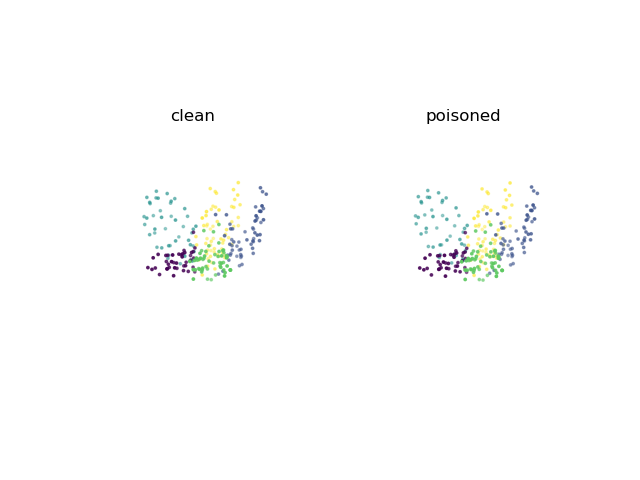

In [70]:
plot_poison(1,vers,gLbls,poisonedVers)

## 4.3 Visualize the poison via a 3d scatter

0.99952024
(155, 4)


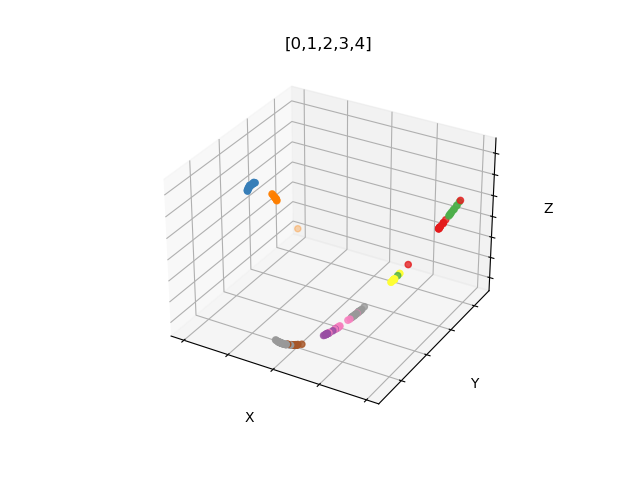

In [101]:
plot_3d_clusters(contraOutCleanTest.detach().numpy(),label_np_test,[i for i in range(10)])

0.99948364
(155, 4)


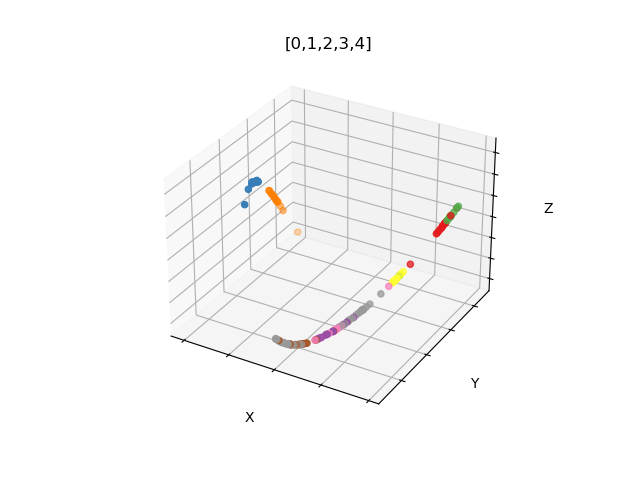

In [102]:
plot_3d_clusters(contraOutPoisonedTest.detach().numpy(),label_np_test,[i for i in range(10)])

# 5 Aftermath

## 5.1 If you would like to save the weights

In [ ]:
saveWeightsDir = 'weights/2-21safdds/'
torch.save(contraG.weights, saveWeightsDir + 'contraGw.pt')
torch.save(contraM.weights, saveWeightsDir + 'contraMw.pt')
torch.save(atkG.weights, saveWeightsDir + 'atkGw.pt') 
torch.save(atkM.weights, saveWeightsDir + 'atkMw.pt')